# REFIT Dataset Preparation

In [ ]:
import pandas as pd
import time
import os
import re

DATASET_NAME = "refit"
DATA_DIRECTORY = 'data/refit/'
AGG_MEAN = 522
AGG_STD = 814
APPLIANCE_NAME = 'washingmachine'
SAVE_PATH = DATASET_NAME + '/' + APPLIANCE_NAME + '/'

params_appliance = {
    'kettle': {
        'windowlength': 599,
        'on_power_threshold': 2000,
        'max_on_power': 3998,
        'mean': 700,
        'std': 1000,
        's2s_length': 128,
        'houses': [2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 19, 20],
        'channels': [8, 9, 9, 8, 7, 9, 9, 7, 6, 9, 5, 9],
        'test_house': 2,
        'validation_house': 5,
        'test_on_train_house': 5,
    },
    'microwave': {
        'windowlength': 599,
        'on_power_threshold': 200,
        'max_on_power': 3969,
        'mean': 500,
        'std': 800,
        's2s_length': 128,
        'houses': [4, 10, 12, 17, 19],
        'channels': [8, 8, 3, 7, 4],
        'test_house': 4,
        'validation_house': 17,
        'test_on_train_house': 10,
    },
    'fridge': {
        'windowlength': 599,
        'on_power_threshold': 50,
        'max_on_power': 3323,
        'mean': 200,
        'std': 400,
        's2s_length': 512,
        'houses': [2, 5, 9, 12, 15],
        'channels': [1, 1, 1,  1, 1],
        'test_house': 15,
        'validation_house': 12,
        'test_on_train_house': 5,
    },
    'dishwasher': {
        'windowlength': 599,
        'on_power_threshold': 10,
        'max_on_power': 3964,
        'mean': 700,
        'std': 1000,
        's2s_length': 1536,
        'houses': [5, 7, 9, 13, 16, 18, 20],
        'channels': [4, 6, 4, 4, 6, 6, 5],
        'test_house': 20,
        'validation_house': 18,
        'test_on_train_house': 13,
    },
    'washingmachine': {
        'windowlength': 599,
        'on_power_threshold': 20,
        'max_on_power': 3999,
        'mean': 400,
        'std': 700,
        's2s_length': 2000,
        'houses': [2, 5, 7, 8, 9, 15, 16, 17, 18],
        'channels': [2, 3, 5, 4, 3, 3, 5, 4, 5],
        'test_house': 8,
        'validation_house': 18,
        'test_on_train_house': 5,
    }
}


def load(path, building, appliance, channel):

    # load csv
    file_name = path + 'CLEAN_House' + str(building) + '.csv'
    single_csv = pd.read_csv(file_name,
                         header=0,
                         names=['aggregate', appliance],
                         usecols=[2, channel+2],
                         na_filter=False,
                         parse_dates=True,
                         memory_map=True)

    return single_csv


def main():
    start_time = time.time()        
    
    appliance_name = APPLIANCE_NAME
    print(appliance_name)
    
    path = DATA_DIRECTORY
    save_path = SAVE_PATH
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    print(path)
    aggregate_mean = AGG_MEAN
    aggregate_std = AGG_STD  
    
    total_length = 0
    print("Starting creating dataset...")
    # Looking for proper files
    for idx, filename in enumerate(os.listdir(path)):
        single_step_time = time.time()
    
        if filename == 'CLEAN_House' + str(params_appliance[appliance_name]['test_house']) + '.csv':
            print('File: ' + filename + ' test set')
            # Loading
            test = load(path,
                 params_appliance[appliance_name]['test_house'],
                 appliance_name,
                 params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses']
                        .index(params_appliance[appliance_name]['test_house'])]
                 )
    
            # Normalization
            test['aggregate'] = (test['aggregate'] - aggregate_mean) / aggregate_std
            test[appliance_name] = \
                (test[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name]['std']
    
            # Save
            test.to_csv(save_path + appliance_name + '_test_' + 'H' + str(params_appliance[appliance_name]['test_house'])
                        + '.csv', index=False)
    
            print("Size of test set is {:.3f} M rows (House {:d})."
                  .format(test.shape[0] / 10 ** 6, params_appliance[appliance_name]['test_house']))
            del test
    
        elif filename == 'CLEAN_House' + str(params_appliance[appliance_name]['validation_house']) + '.csv':
            print('File: ' + filename + ' validation set')
            # Loading
            val = load(path,
                 params_appliance[appliance_name]['validation_house'],
                 appliance_name,
                 params_appliance[appliance_name]['channels']
                 [params_appliance[appliance_name]['houses']
                        .index(params_appliance[appliance_name]['validation_house'])]
                 )
    
            # Normalization
            val['aggregate'] = (val['aggregate'] - aggregate_mean) / aggregate_std
            val[appliance_name] = \
                (val[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name]['std']
    
            # Save
            val.to_csv(save_path + appliance_name + '_validation_' + 'H' + str(params_appliance[appliance_name]['validation_house'])
                       + '.csv', index=False)
    
            print("Size of validation set is {:.3f} M rows (House {:d})."
                  .format(val.shape[0] / 10 ** 6, params_appliance[appliance_name]['validation_house']))
            del val
    
        elif int(re.search(r'\d+', filename).group()) in params_appliance[appliance_name]['houses']:
            print('File: ' + filename)
            print('    House: ' + re.search(r'\d+', filename).group())
    
            # Loading
            try:
                csv = load(path,
                           int(re.search(r'\d+', filename).group()),
                           appliance_name,
                           params_appliance[appliance_name]['channels']
                           [params_appliance[appliance_name]['houses']
                                  .index(int(re.search(r'\d+', filename).group()))]
                           )
    
                # Normalization
                csv['aggregate'] = (csv['aggregate'] - aggregate_mean) / aggregate_std
                csv[appliance_name] = \
                    (csv[appliance_name] - params_appliance[appliance_name]['mean']) / params_appliance[appliance_name][
                        'std']
    
                rows, columns = csv.shape
                total_length += rows
    
                if filename == 'CLEAN_House' + str(params_appliance[appliance_name]['test_on_train_house']) + '.csv':
                    csv.to_csv(save_path + appliance_name + '_test_on_train_' + 'H' + str(
                        params_appliance[appliance_name]['test_on_train_house'])
                               + '.csv', index=False)
                    print("Size of test on train set is {:.3f} M rows (House {:d})."
                          .format(csv.shape[0] / 10 ** 6, params_appliance[appliance_name]['test_on_train_house']))
    
                # saving the whole merged file
                csv.to_csv(save_path + appliance_name + '_training_.csv', mode='a', index=False, header=False)
    
                del csv
    
            except:
                pass
    
    print("Size of training set is {:.3f} M rows.".format(total_length / 10 ** 6))
    print("\nNormalization parameters: ")
    print("Mean and standard deviation values USED for AGGREGATE are:")
    print("    Mean = {:d}, STD = {:d}".format(aggregate_mean, aggregate_std))
    print('Mean and standard deviation values USED for ' + appliance_name + ' are:')
    print("    Mean = {:d}, STD = {:d}"
          .format(params_appliance[appliance_name]['mean'], params_appliance[appliance_name]['std']))
    print("\nTraining, validation and test sets are  in: " + save_path)
    print("Total elapsed time: {:.2f} min.".format((time.time() - start_time) / 60))
    
if __name__ == '__main__':
    main()


# NILM Sequence to Point Model Training with GPU on REFIT Dataset

In [ ]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import tensorflow.keras.backend as K
import glob

# Parameters
appliance_name = "washingmachine" # kettle, dishwasher, fridge, microwave, washingmachine
dataset_name = "refit"
batch_size = 32
crop = 1000
network_type = "seq2point"
training_directory = dataset_name + "/" + appliance_name + "/" + appliance_name + "_training_.csv"
validation_directory = glob.glob(f"{dataset_name}/{appliance_name}/{appliance_name}_validation_H*.csv")[0]
save_model_dir = "saved_models/" + appliance_name + "_" + network_type + "_model.keras"
epochs = 10
input_window_length = 599
validation_frequency = 1
patience = 3
min_delta = 1e-6
verbose = 1
loss = "mse"
metrics = ["mse", "msle", "mae"]
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
shuffle = True

window_size = 2 + input_window_length
window_offset = int((0.5 * window_size) - 1)
offset = window_offset
max_chunk_size = 5 * 10 ** 2
ram_threshold = 5 * 10 ** 5
skip_rows_train = 10000000
validation_steps = 100
skip_rows_val = 0

# Data Loader Function
class TrainSlidingWindowGenerator:
    def __init__(self, file_name, chunk_size, shuffle, offset, batch_size=1000, crop=100000, skip_rows=0, ram_threshold=5 * 10 ** 5):
        self.file_name = file_name
        self.batch_size = batch_size
        self.chunk_size = chunk_size
        self.shuffle = shuffle
        self.offset = offset
        self.crop = crop
        self.skip_rows = skip_rows
        self.ram_threshold = ram_threshold
        self.total_size = 0
        self.total_num_samples = crop

    def load_dataset(self):
        print("Loading dataset from: ", self.file_name)
        data_array = np.array(pd.read_csv(self.file_name, nrows=self.crop, skiprows=self.skip_rows, header=0))
        inputs = data_array[:, 0]
        outputs = data_array[:, 1]
        maximum_batch_size = inputs.size - 2 * self.offset
        self.total_num_samples = maximum_batch_size
        if self.batch_size < 0:
            self.batch_size = maximum_batch_size

        indicies = np.arange(maximum_batch_size)
        if self.shuffle:
            np.random.shuffle(indicies)

        while True:
            for start_index in range(0, maximum_batch_size, self.batch_size):
                splice = indicies[start_index : start_index + self.batch_size]
                input_data = np.array([inputs[index : index + 2 * self.offset + 1] for index in splice])
                output_data = outputs[splice + self.offset].reshape(-1, 1)
                yield input_data, output_data

# Model Creation Function
def create_model(input_window_length):
    input_layer = tf.keras.layers.Input(shape=(input_window_length,))
    reshape_layer = tf.keras.layers.Reshape((1, input_window_length, 1))(input_layer)
    conv_layer_1 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(10, 1), strides=(1, 1), padding="same", activation="relu")(reshape_layer)
    conv_layer_2 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(8, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_1)
    conv_layer_3 = tf.keras.layers.Convolution2D(filters=40, kernel_size=(6, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_2)
    conv_layer_4 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_3)
    conv_layer_5 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_4)
    flatten_layer = tf.keras.layers.Flatten()(conv_layer_5)
    label_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer)
    output_layer = tf.keras.layers.Dense(1, activation="linear")(label_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Load Dataset for Training
training_chunker = TrainSlidingWindowGenerator(file_name=training_directory, 
                                               chunk_size=max_chunk_size,
                                               batch_size=batch_size,
                                               crop=crop,
                                               shuffle=shuffle,
                                               skip_rows=skip_rows_train,
                                               offset=offset,
                                               ram_threshold=ram_threshold)

# Load Dataset for Validation
validation_chunker = TrainSlidingWindowGenerator(file_name=validation_directory, 
                                                 chunk_size=max_chunk_size,
                                                 batch_size=batch_size,
                                                 crop=crop,
                                                 shuffle=False,
                                                 skip_rows=skip_rows_val,
                                                 offset=offset,
                                                 ram_threshold=ram_threshold)

# Create and Compile the Model
model = create_model(input_window_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2), 
              loss=loss, 
              metrics=metrics)

# Set Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=min_delta, patience=patience, verbose=verbose, mode="auto")
callbacks = [early_stopping]

# Calculate Steps per Epoch
steps_per_training_epoch = np.round(int(training_chunker.total_num_samples / batch_size), decimals=0) if training_chunker.total_num_samples is not None else 1

# Train the Model
training_history = model.fit(training_chunker.load_dataset(),
                             validation_data=validation_chunker.load_dataset(),
                             steps_per_epoch=steps_per_training_epoch,
                             epochs=epochs,
                             verbose=verbose,
                             callbacks=callbacks,
                             validation_steps=validation_steps,
                             validation_freq=validation_frequency)

# Save the Model
if not os.path.exists(save_model_dir):
    open((save_model_dir), 'a').close()
model.save(save_model_dir)

# Plot Training Results
plt.plot(training_history.history["loss"], label="MSE (Training Loss)")
if "val_loss" in training_history.history:
    plt.plot(training_history.history["val_loss"], label="MSE (Validation Loss)")
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

del model
# del test_input, test_target, input_data, testing_history
gc.collect()
K.clear_session()


# NILM Sequence to Point Model Inference with GPU on REFIT Dataset

In [ ]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import glob

# Parameters
appliance_name = "washingmachine" # kettle, dishwasher, fridge, microwave, washingmachine
dataset_name = "refit"
batch_size = 1000
crop = 10000
network_type = "seq2point"
input_window_length = 599
test_directory = glob.glob(f"{dataset_name}/{appliance_name}/{appliance_name}_test_H*.csv")[0]
saved_model_dir = "saved_models/" + appliance_name + "_" + network_type + "_model.keras"
log_file_dir = "saved_models/" + appliance_name + "_" + network_type + ".log"

# Appliance data
appliance_data = {
    "kettle": {"mean": 700, "std": 1000},
    "fridge": {"mean": 200, "std": 400},
    "dishwasher": {"mean": 700, "std": 1000},
    "washingmachine": {"mean": 400, "std": 700},
    "microwave": {"mean": 500, "std": 800},
}

# Mains data
mains_data = {"mean": 522, "std": 814}

# Logging setup
logging.basicConfig(filename=log_file_dir, level=logging.INFO)

# Load the test dataset
data_frame = pd.read_csv(test_directory, nrows=crop, skiprows=0, header=0)
test_input = np.round(np.array(data_frame.iloc[:, 0], float), 6)
test_target = np.round(np.array(data_frame.iloc[:, 1], float), 6)
del data_frame

# Load the model
model = tf.keras.models.load_model(saved_model_dir)

# Create sliding windows for inference
window_size = input_window_length + 2
window_offset = int(0.5 * window_size - 1)
number_of_windows = 100
maximum_batch_size = test_input.size - 2 * window_offset
indicies = np.arange(maximum_batch_size)
input_data = np.array([test_input[index : index + 2 * window_offset + 1] for index in indicies[:number_of_windows]])

# Perform inference
start_time = time.time()
testing_history = model.predict(input_data, batch_size=batch_size, verbose=2)
end_time = time.time()
test_time = end_time - start_time

# Log inference time
inference_log = "Inference Time: " + str(test_time)
logging.info(inference_log)

# Denormalize the results
testing_history = ((testing_history * appliance_data[appliance_name]["std"]) + appliance_data[appliance_name]["mean"])
test_target = ((test_target * appliance_data[appliance_name]["std"]) + appliance_data[appliance_name]["mean"])
test_agg = (test_input.flatten() * mains_data["std"]) + mains_data["mean"]
test_agg = test_agg[:maximum_batch_size]

# Remove negative values
test_target[test_target < 0] = 0
testing_history[testing_history < 0] = 0
test_input[test_input < 0] = 0

# Plot results
plt.figure(1)
plt.plot(test_agg[window_offset: -window_offset], label="Aggregate")
plt.plot(test_target[:test_agg.size - (2 * window_offset)], label="Ground Truth")
plt.plot(testing_history[:maximum_batch_size], label="Predicted")
plt.title(appliance_name + " " + network_type)
plt.ylabel("Power Value (Watts)")
plt.xlabel("Testing Window")
plt.legend()
plt.show()


In [ ]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time

# Appliance and Mains Data
appliance_data = {
    "kettle": {
        "mean": 700,
        "std": 1000,
        "houses": [2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 19, 20],
        "channels": [8, 9, 9, 8, 7, 9, 9, 7, 6, 9, 5, 9],
        "test_house": 2,
        "validation_house": 5,
    },
    "fridge": {
        "mean": 200,
        "std": 400,
        "houses": [2, 5, 9, 12, 15],
        "channels": [1, 1, 1, 1, 1],
        "test_house": 15,
        "validation_house": 12
    },
    "dishwasher": {
        "mean": 700,
        "std": 1000,
        "houses": [5, 7, 9, 13, 16, 18, 20],
        "channels": [4, 6, 4, 4, 6, 6, 5],
        "test_house": 9,
        "validation_house": 18,     
    },
    "washingmachine": {
        "mean": 400,
        "std": 700,
        "houses": [2, 5, 7, 8, 9, 15, 16, 17, 18],
        "channels": [2, 3, 5, 4, 3, 3, 5, 4, 5],
        "test_house": 8,
        "validation_house": 18,
    },
    "microwave": {
        "mean": 500,
        "std": 800,
        "houses": [4, 10, 12, 17, 19],
        "channels": [8, 8, 3, 7, 4],
        "test_house": 4,
        "validation_house": 17,
    },
}

mains_data = {
    "mean": 522,
    "std":  814
}

# Model Parameters
input_window_length = 599
appliance_name = "kettle"
algorithm = "seq2point"
network_type = "default"
batch_size = 1000
crop = 10000
test_directory = "dataset_training/refit/kettle/kettle_test_H2.csv"
saved_model_dir = f"saved_models/{appliance_name}_{algorithm}_model.h5"
log_file_dir = f"saved_models/{appliance_name}_{algorithm}_{network_type}.log"

logging.basicConfig(filename=log_file_dir, level=logging.INFO)

# Create Model
input_layer = tf.keras.layers.Input(shape=(input_window_length,))
reshape_layer = tf.keras.layers.Reshape((1, input_window_length, 1))(input_layer)
conv_layer_1 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(10, 1), strides=(1, 1), padding="same", activation="relu")(reshape_layer)
conv_layer_2 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(8, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_1)
conv_layer_3 = tf.keras.layers.Convolution2D(filters=40, kernel_size=(6, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_2)
conv_layer_4 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_3)
conv_layer_5 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_4)
flatten_layer = tf.keras.layers.Flatten()(conv_layer_5)
label_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer)
output_layer = tf.keras.layers.Dense(1, activation="linear")(label_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Load Model
model = tf.keras.models.load_model(saved_model_dir)
num_of_weights = model.count_params()
print("Loaded model with ", str(num_of_weights), " weights")

# Load Dataset
data_frame = pd.read_csv(test_directory, nrows=crop, skiprows=0, header=0)
test_input = np.round(np.array(data_frame.iloc[:, 0], float), 6)
test_target = np.round(np.array(data_frame.iloc[int(0.5 * (input_window_length + 2) - 1): -int(0.5 * (input_window_length + 2) - 1), 1], float), 6)
del data_frame

# Test Data Generator
window_offset = int(0.5 * (input_window_length + 2) - 1)
number_of_windows = 100
test_input = test_input.flatten()
max_number_of_windows = test_input.size - 2 * window_offset
indicies = np.arange(max_number_of_windows, dtype=int)

def test_data_generator():
    for start_index in range(0, max_number_of_windows, number_of_windows):
        splice = indicies[start_index : start_index + number_of_windows]
        input_data = np.array([test_input[index : index + 2 * window_offset + 1] for index in splice])
        target_data = test_target[splice + window_offset].reshape(-1, 1)
        yield input_data, target_data

steps_per_test_epoch = np.round(int(len(test_input) / batch_size), decimals=0)

# Test Model
start_time = time.time()
testing_history = model.predict(x=test_data_generator(), steps=steps_per_test_epoch, verbose=2)
end_time = time.time()
test_time = end_time - start_time

evaluation_metrics = model.evaluate(x=test_data_generator(), steps=steps_per_test_epoch)

# Log Results
inference_log = "Inference Time: " + str(test_time)
logging.info(inference_log)

metric_string = f"MSE: {evaluation_metrics[0]} MAE: {evaluation_metrics[1]}"
logging.info(metric_string)

# Plot Results
testing_history = ((testing_history * appliance_data[appliance_name]["std"]) + appliance_data[appliance_name]["mean"])
test_target = ((test_target * appliance_data[appliance_name]["std"]) + appliance_data[appliance_name]["mean"])
test_agg = (test_input.flatten() * mains_data["std"]) + mains_data["mean"]
test_agg = test_agg[:testing_history.size]

test_target[test_target < 0] = 0
testing_history[testing_history < 0] = 0
test_input[test_input < 0] = 0

plt.figure(1)
plt.plot(test_agg[window_offset: -window_offset], label="Aggregate")
plt.plot(test_target[:test_agg.size - (2 * window_offset)], label="Ground Truth")
plt.plot(testing_history[:test_agg.size - (2 * window_offset)], label="Predicted")
plt.title(appliance_name + " " + network_type + "(" + algorithm + ")")
plt.ylabel("Power Value (Watts)")
plt.xlabel("Testing Window")
plt.legend()
plt.show()

# UKDALE Dataset Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

# Default Variables
DATASET_NAME = "ukdale"
APPLIANCE_NAME = 'dishwasher'
DATA_DIRECTORY = f"data/{DATASET_NAME}/"
SAVE_PATH = f"data_train_test/{DATASET_NAME}/{APPLIANCE_NAME}/"
AGG_MEAN = 522
AGG_STD = 814
AGGREGATE_MEAN = AGG_MEAN
AGGREGATE_STD = AGG_STD

# Parameters
appliance_name = APPLIANCE_NAME
data_dir = DATA_DIRECTORY
save_path = SAVE_PATH
aggregate_mean = AGGREGATE_MEAN
aggregate_std = AGGREGATE_STD

if not os.path.exists(save_path):
    os.makedirs(save_path)

# Execution Start
start_time = time.time()
sample_seconds = 8
training_building_percent = 95
validation_percent = 13
nrows = None
debug = False

train = pd.DataFrame(columns=['aggregate', appliance_name])

params_appliance = {
    'kettle': {
        'windowlength': 599,
        'on_power_threshold': 2000,
        'max_on_power': 3998,
        'mean': 700,
        'std': 1000,
        's2s_length': 128,
        'houses': [1, 2],
        'channels': [10, 8],
        'train_build': [1],
        'test_build': 2,
    },
    'microwave': {
        'windowlength': 599,
        'on_power_threshold': 200,
        'max_on_power': 3969,
        'mean': 500,
        'std': 800,
        's2s_length': 128,
        'houses': [1, 2],
        'channels': [13, 15],
        'train_build': [1],
        'test_build': 2,
    },
    'fridge': {
        'windowlength': 599,
        'on_power_threshold': 50,
        'max_on_power': 3323,
        'mean': 200,
        'std': 400,
        's2s_length': 512,
        'houses': [1, 2],
        'channels': [12, 14],
        'train_build': [1],
        'test_build': 2,
    },
    'dishwasher': {
        'windowlength': 599,
        'on_power_threshold': 10,
        'max_on_power': 3964,
        'mean': 700,
        'std': 1000,
        's2s_length': 1536,
        'houses': [1, 2],
        'channels': [6, 13],
        'train_build': [1],
        'test_build': 2,
    },
    'washingmachine': {
        'windowlength': 599,
        'on_power_threshold': 20,
        'max_on_power': 3999,
        'mean': 400,
        'std': 700,
        's2s_length': 2000,
        'houses': [1, 2],
        'channels': [5, 12],
        'train_build': [1],
        'test_build': 2,
    }
}

def load_dataframe(directory, building, channel, col_names=['time', 'data'], nrows=None):
    df = pd.read_table(directory + 'house_' + str(building) + '/' + 'channel_' +
                       str(channel) + '.dat',
                       sep="\s+",
                       nrows=nrows,
                       usecols=[0, 1],
                       names=col_names,
                       dtype={'time': str},
                       )
    return df

# Process Data
for h in params_appliance[appliance_name]['houses']:
    print('    ' + data_dir + 'house_' + str(h) + '/'
          + 'channel_' +
          str(params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses'].index(h)]) +
          '.dat')

    mains_df = load_dataframe(data_dir, h, 1)
    app_df = load_dataframe(data_dir,
                            h,
                            params_appliance[appliance_name]['channels'][params_appliance[appliance_name]['houses'].index(h)],
                            col_names=['time', appliance_name]
                            )

    mains_df['time'] = pd.to_datetime(mains_df['time'], unit='s')
    mains_df.set_index('time', inplace=True)
    mains_df.columns = ['aggregate']
    mains_df.reset_index(inplace=True)

    if debug:
        print("    mains_df:")
        print(mains_df.head())
        plt.plot(mains_df['time'], mains_df['aggregate'])
        plt.show()

    app_df['time'] = pd.to_datetime(app_df['time'], unit='s')

    if debug:
        print("app_df:")
        print(app_df.head())
        plt.plot(app_df['time'], app_df[appliance_name])
        plt.show()

    # Align timestamps
    mains_df.set_index('time', inplace=True)
    app_df.set_index('time', inplace=True)

    df_align = mains_df.join(app_df, how='outer').resample(str(sample_seconds) + 'S').mean().fillna(method='backfill', limit=1)
    df_align = df_align.dropna()
    df_align.reset_index(inplace=True)

    del mains_df, app_df, df_align['time']

    if debug:
        print("df_align:")
        print(df_align.head())
        plt.plot(df_align['aggregate'].values)
        plt.plot(df_align[appliance_name].values)
        plt.show()

    # Normalization
    mean = params_appliance[appliance_name]['mean']
    std = params_appliance[appliance_name]['std']

    df_align['aggregate'] = (df_align['aggregate'] - aggregate_mean) / aggregate_std
    df_align[appliance_name] = (df_align[appliance_name] - mean) / std

    if h == params_appliance[appliance_name]['test_build']:
        df_align.to_csv(save_path + appliance_name + '_test_.csv', mode='a', index=False, header=False)
        print("    Size of test set is {:.4f} M rows.".format(len(df_align) / 10 ** 6))
        continue

    train = pd.concat([train, df_align], ignore_index=True)
    del df_align

# Crop Training Data
if training_building_percent != 0:
    train.drop(train.index[-int((len(train)/100)*training_building_percent):], inplace=True)

# Validation Set
val_len = int((len(train)/100)*validation_percent)
val = train.tail(val_len)
val.reset_index(drop=True, inplace=True)
train.drop(train.index[-val_len:], inplace=True)

val.to_csv(save_path + appliance_name + '_validation_' + '.csv', mode='a', index=False, header=False)

# Training Set
train.to_csv(save_path + appliance_name + '_training_.csv', mode='a', index=False, header=False)

print("    Size of total training set is {:.4f} M rows.".format(len(train) / 10 ** 6))
print("    Size of total validation set is {:.4f} M rows.".format(len(val) / 10 ** 6))
del train, val

print("\nPlease find files in: " + save_path)
print("Total elapsed time: {:.2f} min.".format((time.time() - start_time) / 60))


    data/ukdale/house_1/channel_6.dat


/tmp/ipykernel_5366/3313919359.py:124: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  mains_df['time'] = pd.to_datetime(mains_df['time'], unit='s')
/tmp/ipykernel_5366/3313919359.py:135: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  app_df['time'] = pd.to_datetime(app_df['time'], unit='s')


    data/ukdale/house_2/channel_13.dat


/tmp/ipykernel_5366/3313919359.py:124: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  mains_df['time'] = pd.to_datetime(mains_df['time'], unit='s')
/tmp/ipykernel_5366/3313919359.py:135: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  app_df['time'] = pd.to_datetime(app_df['time'], unit='s')


    Size of test set is 0.1620 M rows.
    Size of total training set is 0.0925 M rows.
    Size of total validation set is 0.0138 M rows.

Please find files in: data_train_test/ukdale/dishwasher/
Total elapsed time: 5.18 min.


# NILM Sequence to Point Model Training with GPU on UKDALE Dataset

2025-01-02 08:42:20.105468: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 08:42:20.391974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 08:42:20.393566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-02 08:42:21.337193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-01-02 08:42:23.160828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

Loading dataset from:  data_train_test/ukdale/dishwasher/dishwasher_training_.csv
Epoch 1/10
31/31 [==============================] - 10s 295ms/step - loss: 0.0891 - mse: 0.0891 - msle: 0.0044 - mae: 0.2073 - val_loss: 0.0181 - val_mse: 0.0181 - val_msle: 0.0000e+00 - val_mae: 0.1345
Epoch 2/10
31/31 [==============================] - 9s 293ms/step - loss: 0.0373 - mse: 0.0373 - msle: 0.0056 - mae: 0.0667 - val_loss: 0.0011 - val_mse: 0.0011 - val_msle: 0.0000e+00 - val_mae: 0.0332
Epoch 3/10
31/31 [==============================] - 9s 295ms/step - loss: 0.0612 - mse: 0.0612 - msle: 0.0101 - mae: 0.0638 - val_loss: 0.0081 - val_mse: 0.0081 - val_msle: 0.0000e+00 - val_mae: 0.0902
Epoch 4/10
31/31 [==============================] - 9s 296ms/step - loss: 0.0360 - mse: 0.0360 - msle: 0.0056 - mae: 0.0676 - val_loss: 0.0015 - val_mse: 0.0015 - val_msle: 0.0000e+00 - val_mae: 0.0393
Epoch 5/10
31/31 [==============================] - 9s 295ms/step - loss: 0.0179 - mse: 0.0179 - msle: 0.0029

/home/vegaai/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


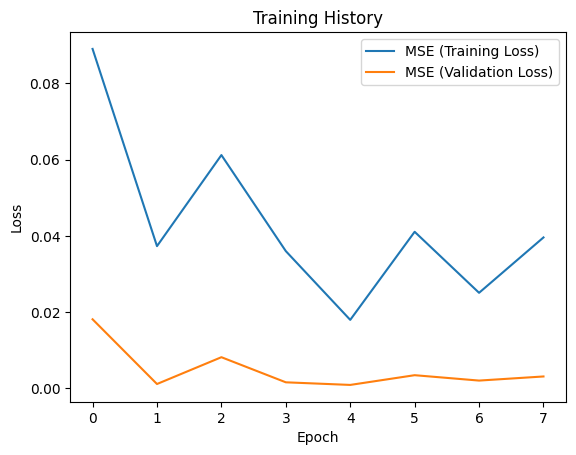

In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import tensorflow.keras.backend as K
import glob

# Parameters
appliance_name = "dishwasher" # kettle, dishwasher, fridge, microwave, washingmachine
dataset_name = "ukdale"
batch_size = 32
crop = 1000
network_type = "seq2point"
training_directory = f"data_train_test/{dataset_name}/{appliance_name}/{appliance_name}_training_.csv"
validation_directory = f"data_train_test/{dataset_name}/{appliance_name}/{appliance_name}_validation_.csv"
save_model_dir = "saved_models/"+ dataset_name + "/" + appliance_name + "_model.h5"
epochs = 10
input_window_length = 599
validation_frequency = 1
patience = 3
min_delta = 1e-6
verbose = 1
loss = "mse"
metrics = ["mse", "msle", "mae"]
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
shuffle = True

window_size = 2 + input_window_length
window_offset = int((0.5 * window_size) - 1)
offset = window_offset
max_chunk_size = 5 * 10 ** 2
ram_threshold = 5 * 10 ** 5
skip_rows_train = 10000000
validation_steps = 100
skip_rows_val = 0

# Data Loader Function
class TrainSlidingWindowGenerator:
    def __init__(self, file_name, chunk_size, shuffle, offset, batch_size=1000, crop=90000, skip_rows=0, ram_threshold=5 * 10 ** 5):
        self.file_name = file_name
        self.batch_size = batch_size
        self.chunk_size = chunk_size
        self.shuffle = shuffle
        self.offset = offset
        self.crop = crop
        self.skip_rows = skip_rows
        self.ram_threshold = ram_threshold
        self.total_size = 0
        self.total_num_samples = crop

    def load_dataset(self):
        print("Loading dataset from: ", self.file_name)
        try:
            data_array = np.array(pd.read_csv(self.file_name, nrows=self.crop, skiprows=self.skip_rows, header=None))
            
        except:
            data_array = np.array(pd.read_csv(self.file_name, header=None, skip_blank_lines=True, delimiter=','))
        inputs = data_array[:, 0]
        outputs = data_array[:, 1]
        maximum_batch_size = inputs.size - 2 * self.offset
        self.total_num_samples = maximum_batch_size
        if self.batch_size < 0:
            self.batch_size = maximum_batch_size

        indicies = np.arange(maximum_batch_size)
        if self.shuffle:
            np.random.shuffle(indicies)

        while True:
            for start_index in range(0, maximum_batch_size, self.batch_size):
                splice = indicies[start_index : start_index + self.batch_size]
                input_data = np.array([inputs[index : index + 2 * self.offset + 1] for index in splice])
                output_data = outputs[splice + self.offset].reshape(-1, 1)
                yield input_data, output_data

# Model Creation Function
def create_model(input_window_length):
    input_layer = tf.keras.layers.Input(shape=(input_window_length,))
    reshape_layer = tf.keras.layers.Reshape((1, input_window_length, 1))(input_layer)
    conv_layer_1 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(10, 1), strides=(1, 1), padding="same", activation="relu")(reshape_layer)
    conv_layer_2 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(8, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_1)
    conv_layer_3 = tf.keras.layers.Convolution2D(filters=40, kernel_size=(6, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_2)
    conv_layer_4 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_3)
    conv_layer_5 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_4)
    flatten_layer = tf.keras.layers.Flatten()(conv_layer_5)
    label_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer)
    output_layer = tf.keras.layers.Dense(1, activation="linear")(label_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Load Dataset for Training
training_chunker = TrainSlidingWindowGenerator(file_name=training_directory, 
                                               chunk_size=max_chunk_size,
                                               batch_size=batch_size,
                                               crop=crop,
                                               shuffle=shuffle,
                                               skip_rows=skip_rows_train,
                                               offset=offset,
                                               ram_threshold=ram_threshold)

# Load Dataset for Validation
validation_chunker = TrainSlidingWindowGenerator(file_name=validation_directory, 
                                                 chunk_size=max_chunk_size,
                                                 batch_size=batch_size,
                                                 crop=crop,
                                                 shuffle=False,
                                                 skip_rows=skip_rows_val,
                                                 offset=offset,
                                                 ram_threshold=ram_threshold)

# Create and Compile the Model
model = create_model(input_window_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2), 
              loss=loss, 
              metrics=metrics)

# Set Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=min_delta, patience=patience, verbose=verbose, mode="auto")
callbacks = [early_stopping]

# Calculate Steps per Epoch
steps_per_training_epoch = np.round(int(training_chunker.total_num_samples / batch_size), decimals=0) if training_chunker.total_num_samples is not None else 1

# Train the Model
training_history = model.fit(training_chunker.load_dataset(),
                             validation_data=validation_chunker.load_dataset(),
                             steps_per_epoch=steps_per_training_epoch,
                             epochs=epochs,
                             verbose=verbose,
                             callbacks=callbacks,
                             validation_steps=validation_steps,
                             validation_freq=validation_frequency)

# Save the Model
if not os.path.exists(save_model_dir):
    open((save_model_dir), 'a').close()
model.save(save_model_dir)

# Plot Training Results
plt.plot(training_history.history["loss"], label="MSE (Training Loss)")
if "val_loss" in training_history.history:
    plt.plot(training_history.history["val_loss"], label="MSE (Validation Loss)")
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

del model
# del test_input, test_target, input_data, testing_history
gc.collect()
K.clear_session()

# NILM Sequence to Point Model Inference with GPU on UKDALE Dataset

2025-01-03 08:19:10.544641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 08:19:10.824816: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 08:19:10.826345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-03 08:19:11.676947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-01-03 08:19:13.466454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

PATH NAME:  saved_models/ukdale/dishwasher_model.h5
Loaded model with  30708249  weights
10/10 - 0s - 402ms/epoch - 40ms/step
10/10 [==============================] - 0s 29ms/step - loss: 0.1394 - mse: 0.1394 - msle: 0.0222 - mae: 0.1216
LOGGING PATH:  saved_models/ukdale/dishwasher_seq2point_.log


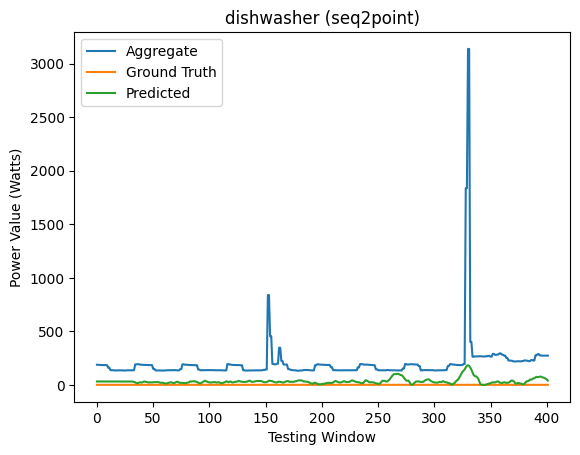

In [1]:
import argparse
import os
import logging
import numpy as np 
import keras
import pandas as pd
import tensorflow as tf 
import time
import matplotlib.pyplot as plt

appliance_data = {
    "kettle": {
        "mean": 700,
        "std": 1000,
        "houses": [2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 19, 20],
        "channels": [8, 9, 9, 8, 7, 9, 9, 7, 6, 9, 5, 9],
        "test_house": 2,
        "validation_house": 5,
    },
    "fridge": {
        "mean": 200,
        "std": 400,
        "houses": [2, 5, 9, 12, 15],
        "channels": [1, 1, 1, 1, 1],
        "test_house": 15,
        "validation_house": 12
    },
    "dishwasher": {
        "mean": 700,
        "std": 1000,
        "houses": [5, 7, 9, 13, 16, 18, 20],
        "channels": [4, 6, 4, 4, 6, 6, 5],
        "test_house": 9,
        "validation_house": 18,     
    },
    "washingmachine": {
        "mean": 400,
        "std": 700,
        "houses": [2, 5, 7, 8, 9, 15, 16, 17, 18],
        "channels": [2, 3, 5, 4, 3, 3, 5, 4, 5],
        "test_house": 8,
        "validation_house": 18,
    },
    "microwave": {
        "mean": 500,
        "std": 800,
        "houses": [4, 10, 12, 17, 19],
        "channels": [8, 8, 3, 7, 4],
        "test_house": 4,
        "validation_house": 17,
    },
}

mains_data = {
    "mean": 522,
    "std":  814        
    }

class TrainSlidingWindowGenerator():

    def __init__(self, 
                file_name, 
                chunk_size, 
                shuffle, 
                offset, 
                batch_size=1000, 
                crop=100000, 
                skip_rows=0, 
                ram_threshold=5 * 10 ** 5):
        self.__file_name = file_name
        self.__batch_size = batch_size
        self.__chunk_size = 10 ** 8
        self.__shuffle = shuffle
        self.__offset = offset
        self.__crop = crop
        self.__skip_rows = skip_rows
        self.__ram_threshold = ram_threshold
        self.total_size = 0
        self.__total_num_samples = crop

    @property
    def total_num_samples(self):
        return self.__total_num_samples
    
    @total_num_samples.setter
    def total_num_samples(self, value):
        self.__total_num_samples = value

    def check_if_chunking(self):

        # Loads the file and counts the number of rows it contains.
        print("Importing training file...")
        chunks = pd.read_csv(self.__file_name, 
                            header=0, 
                            nrows=self.__crop, 
                            skiprows=self.__skip_rows)
        print("Counting number of rows...")
        self.total_size = len(chunks)
        del chunks
        print("Done.")

        print("The dataset contains ", self.total_size, " rows")

        # Display a warning if there are too many rows to fit in the designated amount RAM.
        if (self.total_size > self.__ram_threshold):
            print("There is too much data to load into memory, so it will be loaded in chunks. Please note that this may result in decreased training times.")
    

    def load_dataset(self):

        if self.total_size == 0:
            self.check_if_chunking()

        # If the data can be loaded in one go, don't skip any rows.
        if (self.total_size <= self.__ram_threshold):

            # Returns an array of the content from the CSV file.
            data_array = np.array(pd.read_csv(self.__file_name, nrows=self.__crop, skiprows=self.__skip_rows, header=0))
            inputs = data_array[:, 0]
            outputs = data_array[:, 1]

            maximum_batch_size = inputs.size - 2 * self.__offset
            self.total_num_samples = maximum_batch_size
            if self.__batch_size < 0:
                self.__batch_size = maximum_batch_size

            indicies = np.arange(maximum_batch_size)
            if self.__shuffle:
                np.random.shuffle(indicies)

            while True:
                for start_index in range(0, maximum_batch_size, self.__batch_size):
                    splice = indicies[start_index : start_index + self.__batch_size]
                    input_data = np.array([inputs[index : index + 2 * self.__offset + 1] for index in splice])
                    output_data = outputs[splice + self.__offset].reshape(-1, 1)

                    yield input_data, output_data
                    
        # Skip rows where needed to allow data to be loaded properly when there is not enough memory.
        if (self.total_size >= self.__ram_threshold):
            number_of_chunks = np.arange(self.total_size / self.__chunk_size)
            if self.__shuffle:
                np.random.shuffle(number_of_chunks)

            # Yield the data in sections.
            for index in number_of_chunks:
                data_array = np.array(pd.read_csv(self.__file_name, skiprows=int(index) * self.__chunk_size, header=0, nrows=self.__crop))                   
                inputs = data_array[:, 0]
                outputs = data_array[:, 1]

                maximum_batch_size = inputs.size - 2 * self.__offset
                self.total_num_samples = maximum_batch_size
                if self.__batch_size < 0:
                    self.__batch_size = maximum_batch_size

                indicies = np.arange(maximum_batch_size)
                if self.__shuffle:
                    np.random.shuffle(indicies)

            while True:
                for start_index in range(0, maximum_batch_size, self.__batch_size):
                    splice = indicies[start_index : start_index + self.__batch_size]
                    input_data = np.array([inputs[index : index + 2 * self.__offset + 1] for index in splice])
                    output_data = outputs[splice + self.__offset].reshape(-1, 1)

                    yield input_data, output_data
                    
class TestSlidingWindowGenerator(object):

    def __init__(self, number_of_windows, inputs, targets, offset):
        self.__number_of_windows = number_of_windows
        self.__offset = offset
        self.__inputs = inputs
        self.__targets = targets
        self.total_size = len(inputs)

    def load_dataset(self):

        self.__inputs = self.__inputs.flatten()
        max_number_of_windows = self.__inputs.size - 2 * self.__offset

        if self.__number_of_windows < 0:
            self.__number_of_windows = max_number_of_windows

        indicies = np.arange(max_number_of_windows, dtype=int)
        for start_index in range(0, max_number_of_windows, self.__number_of_windows):
            splice = indicies[start_index : start_index + self.__number_of_windows]
            input_data = np.array([self.__inputs[index : index + 2 * self.__offset + 1] for index in splice])
            target_data = self.__targets[splice + self.__offset].reshape(-1, 1)
            yield input_data, target_data

def create_model(input_window_length):

    input_layer = tf.keras.layers.Input(shape=(input_window_length,))
    reshape_layer = tf.keras.layers.Reshape((1, input_window_length, 1))(input_layer)
    conv_layer_1 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(10, 1), strides=(1, 1), padding="same", activation="relu")(reshape_layer)
    conv_layer_2 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(8, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_1)
    conv_layer_3 = tf.keras.layers.Convolution2D(filters=40, kernel_size=(6, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_2)
    conv_layer_4 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_3)
    conv_layer_5 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_4)
    flatten_layer = tf.keras.layers.Flatten()(conv_layer_5)
    label_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer)
    output_layer = tf.keras.layers.Dense(1, activation="linear")(label_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

def load_model(model, network_type, algorithm, appliance, saved_model_dir):

    #model_name = "saved_models/" + appliance + "_" + algorithm + "_" + network_type + "_model.h5"
    model_name = saved_model_dir
    print("PATH NAME: ", model_name)

    model = tf.keras.models.load_model(model_name)
    num_of_weights = model.count_params()
    print("Loaded model with ", str(num_of_weights), " weights")
    return model

class Tester():

    def __init__(self, appliance, algorithm, crop, batch_size, network_type,
                 test_directory, saved_model_dir, log_file_dir,
                 input_window_length):
        self.__appliance = appliance
        self.__algorithm = algorithm
        self.__network_type = network_type

        self.__crop = crop
        self.__batch_size = batch_size
        self._input_window_length = input_window_length
        self.__window_size = self._input_window_length + 2
        self.__window_offset = int(0.5 * self.__window_size - 1)
        self.__number_of_windows = 100

        self.__test_directory = test_directory
        self.__saved_model_dir = saved_model_dir

        self.__log_file = log_file_dir
        logging.basicConfig(filename=self.__log_file,level=logging.INFO)

    def test_model(self):

        test_input, test_target = self.load_dataset(self.__test_directory)
        model = create_model(self._input_window_length)
        model = load_model(model, self.__network_type, self.__algorithm, 
                           self.__appliance, self.__saved_model_dir)

        test_generator = TestSlidingWindowGenerator(number_of_windows=self.__number_of_windows, inputs=test_input, targets=test_target, offset=self.__window_offset)

        # Calculate the optimum steps per epoch.
        steps_per_test_epoch = np.round(int(test_generator.total_size / self.__batch_size), decimals=0)

        # Test the model.
        start_time = time.time()
        testing_history = model.predict(x=test_generator.load_dataset(), steps=steps_per_test_epoch, verbose=2)

        end_time = time.time()
        test_time = end_time - start_time

        evaluation_metrics = model.evaluate(x=test_generator.load_dataset(), steps=steps_per_test_epoch)

        self.log_results(model, test_time, evaluation_metrics)
        self.plot_results(testing_history, test_input, test_target)


    def load_dataset(self, directory):

        data_frame = pd.read_csv(directory, nrows=self.__crop, skiprows=0, header=0)
        test_input = np.round(np.array(data_frame.iloc[:, 0], float), 6)
        test_target = np.round(np.array(data_frame.iloc[self.__window_offset: -self.__window_offset, 1], float), 6)
        
        del data_frame
        return test_input, test_target

    def log_results(self, model, test_time, evaluation_metrics):

        inference_log = "Inference Time: " + str(test_time)
        logging.info(inference_log)

        metric_string = "MSE: ", str(evaluation_metrics[0]), " MAE: ", str(evaluation_metrics[3])
        logging.info(metric_string)

        self.count_pruned_weights(model)  

    
    def count_pruned_weights(self, model):
        num_total_zeros = 0
        num_dense_zeros = 0
        num_dense_weights = 0
        num_conv_zeros = 0
        num_conv_weights = 0

        for layer in model.layers:
            weights = layer.get_weights()
            if weights:  # Check if the layer has weights
                for w in weights:
                    if np.asarray(w).size != 0:  # Ensure it's a non-empty array
                        w_array = np.asarray(w).flatten()

                        if "conv" in layer.name:
                            num_conv_weights += np.size(w_array)
                            num_conv_zeros += np.count_nonzero(w_array == 0)

                            num_total_zeros += np.size(w_array)
                        else:
                            num_dense_weights += np.size(w_array)
                            num_dense_zeros += np.count_nonzero(w_array == 0)

        conv_zeros_string = "CONV. ZEROS: " + str(num_conv_zeros)
        conv_weights_string = "CONV. WEIGHTS: " + str(num_conv_weights)
        conv_sparsity_ratio = "CONV. RATIO: " + str(num_conv_zeros / num_conv_weights if num_conv_weights > 0 else 0)

        dense_weights_string = "DENSE WEIGHTS: " + str(num_dense_weights)
        dense_zeros_string = "DENSE ZEROS: " + str(num_dense_zeros)
        dense_sparsity_ratio = "DENSE RATIO: " + str(num_dense_zeros / num_dense_weights if num_dense_weights > 0 else 0)

        total_zeros_string = "TOTAL ZEROS: " + str(num_total_zeros)
        total_weights_string = "TOTAL WEIGHTS: " + str(model.count_params())
        total_sparsity_ratio = "TOTAL RATIO: " + str(num_total_zeros / model.count_params())

        print("LOGGING PATH: ", self.__log_file)

        logging.info(conv_zeros_string)
        logging.info(conv_weights_string)
        logging.info(conv_sparsity_ratio)
        logging.info("")
        logging.info(dense_zeros_string)
        logging.info(dense_weights_string)
        logging.info(dense_sparsity_ratio)
        logging.info("")
        logging.info(total_zeros_string)
        logging.info(total_weights_string)
        logging.info(total_sparsity_ratio)


    def plot_results(self, testing_history, test_input, test_target):

        testing_history = ((testing_history * appliance_data[self.__appliance]["std"]) + appliance_data[self.__appliance]["mean"])
        test_target = ((test_target * appliance_data[self.__appliance]["std"]) + appliance_data[self.__appliance]["mean"])
        test_agg = (test_input.flatten() * mains_data["std"]) + mains_data["mean"]
        test_agg = test_agg[:testing_history.size]

        # Can't have negative energy readings - set any results below 0 to 0.
        test_target[test_target < 0] = 0
        testing_history[testing_history < 0] = 0
        test_input[test_input < 0] = 0

        plt.figure(1)
        plt.plot(test_agg[self.__window_offset: -self.__window_offset], label="Aggregate")
        plt.plot(test_target[:test_agg.size - (2 * self.__window_offset)], label="Ground Truth")
        plt.plot(testing_history[:test_agg.size - (2 * self.__window_offset)], label="Predicted")
        plt.title(self.__appliance + " " + self.__network_type + "(" + self.__algorithm + ")")
        plt.ylabel("Power Value (Watts)")
        plt.xlabel("Testing Window")
        plt.legend()
        plt.show()

def remove_space(string):
    return string.replace(" ","")

appliance_name = "dishwasher"
dataset_name = "ukdale"
batch_size = 1000
crop = 10000
algorithm = "seq2point"
network_type = ""
input_window_length = 599
test_directory = f"data_train_test/{dataset_name}/{appliance_name}/{appliance_name}_test_.csv"
saved_model_dir = f"saved_models/{dataset_name}/{appliance_name}_model.h5"
log_file_dir = f"saved_models/{dataset_name}/{appliance_name}_{algorithm}_{network_type}.log"

tester = Tester(
    appliance=appliance_name,
    algorithm=algorithm,
    crop=crop,
    batch_size=batch_size,
    network_type=network_type,
    test_directory=test_directory,
    saved_model_dir=saved_model_dir,
    log_file_dir=log_file_dir,
    input_window_length=input_window_length
)
tester.test_model()

# All Appliances

In [4]:
import pandas as pd
import os
import time

# Default Variables
DATASET_NAME = "ukdale"
DATA_DIRECTORY = f"data/{DATASET_NAME}/"
SAVE_PATH = f"data_train_test/{DATASET_NAME}/all_appliances/"
AGG_MEAN = 522
AGG_STD = 814
SAMPLE_SECONDS = 8
WINDOW_LENGTH = 599
CHUNK_SIZE = 100000  # Adjust this to fit available memory

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Appliance Parameters
params_appliance = {
    'kettle': {'channels': [10, 8]},
    'microwave': {'channels': [13, 15]},
    'fridge': {'channels': [12, 14]},
    'dishwasher': {'channels': [6, 13]},
    'washingmachine': {'channels': [5, 12]}
}

# Load Data Function
def load_dataframe(directory, building, channel, col_names=['time', 'data'], nrows=None):
    df = pd.read_table(directory + f'house_{building}/channel_{channel}.dat',
                       sep="\s+",
                       nrows=nrows,
                       usecols=[0, 1],
                       names=col_names,
                       dtype={'time': str})
    return df

# Execution Start
start_time = time.time()
all_data = []

for house in [1, 2]:  # Iterate through all houses in the dataset
    print(f"Processing house {house}...")

    # Load Aggregate Data
    mains_df = load_dataframe(DATA_DIRECTORY, house, 1, col_names=['time', 'aggregate'])
    mains_df['time'] = pd.to_datetime(mains_df['time'], unit='s')
    mains_df.set_index('time', inplace=True)

    # Initialize a DataFrame to store appliance data
    appliance_data = mains_df.copy()

    for appliance, params in params_appliance.items():
        channel = params['channels'][0 if house == 1 else 1]  # Select channel based on house
        app_df = load_dataframe(DATA_DIRECTORY, house, channel, col_names=['time', appliance])

        app_df['time'] = pd.to_datetime(app_df['time'], unit='s')
        app_df.set_index('time', inplace=True)

        # Align appliance data with aggregate data in chunks
        for chunk_start in range(0, len(app_df), CHUNK_SIZE):
            app_chunk = app_df.iloc[chunk_start:chunk_start + CHUNK_SIZE]
            appliance_data = appliance_data.join(app_chunk, how='outer')

    # Resample and Fill Missing Data
    appliance_data = appliance_data.resample(f"{SAMPLE_SECONDS}S").mean().fillna(method='backfill', limit=1)
    appliance_data = appliance_data.dropna()
    
    # Normalize Data
    appliance_data['aggregate'] = (appliance_data['aggregate'] - AGG_MEAN) / AGG_STD
    for appliance in params_appliance.keys():
        mean = params_appliance[appliance].get('mean', 700)
        std = params_appliance[appliance].get('std', 1000)
        appliance_data[appliance] = (appliance_data[appliance] - mean) / std

    # Convert Data to Sliding Windows
    appliance_values = appliance_data.values
    for i in range(len(appliance_values) - WINDOW_LENGTH + 1):
        window = appliance_values[i:i + WINDOW_LENGTH]
        all_data.append(window)

    # Clear memory for the current house before processing the next
    del appliance_data

# Save Processed Data
all_data = pd.DataFrame(all_data, columns=[f"aggregate"] + list(params_appliance.keys()))
all_data.to_csv(SAVE_PATH + "all_appliances_data.csv", index=False)

print("Processing complete.")
print(f"Total elapsed time: {(time.time() - start_time) / 60:.2f} minutes.")


Processing house 1...


/tmp/ipykernel_5744/648075501.py:46: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  mains_df['time'] = pd.to_datetime(mains_df['time'], unit='s')
/tmp/ipykernel_5744/648075501.py:56: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  app_df['time'] = pd.to_datetime(app_df['time'], unit='s')


ValueError: columns overlap but no suffix specified: Index(['kettle'], dtype='object')